In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [127]:
# Semilla para reproducibilidad
# torch.manual_seed(42)
# np.random.seed(42)

Cargar Dataset:

Este conjunto de datos contiene series temporales mensuales de variables climáticas entre 1950 y 2016, utilizadas en un estudio sobre la influencia de los océanos Pacífico y Atlántico en la precipitación del noreste de Brasil.


In [128]:
# Ruta al archivo CSV
file_path = r"C:\Users\LENOVO\OneDrive\Desktop\python\!erpractica\JCruz2023_ICCSA.csv"
# Intentar cargar con parse_dates para la columna 'date' 
df = pd.read_csv(file_path, parse_dates=['date'])
df = df.sort_values(by="date").reset_index(drop=True) #Reinicia los índices del DataFrame después de ordenar por el date 

In [129]:
print("\n=== Primeras 5 filas ===")
print(df.head())
print("Estadísticas del dataset:")
print(df.describe())
print(df.columns.size)



=== Primeras 5 filas ===
        date    NEB_mean  NEB_highest  NEB_lowest       RUKZ       AtlN   ONI  \
0 1950-01-01   53.329311   104.550003    7.360000  13.440676  24.617685 -1.53   
1 1950-02-01   75.436207   120.739998   15.600000   4.860598  24.005806 -1.34   
2 1950-03-01  224.097242   320.170013   72.540001   6.228437  24.031051 -1.16   
3 1950-04-01  285.313335   416.250000  143.240005  13.050443  24.689106 -1.18   
4 1950-05-01   67.016321    85.250000   74.660004  35.541031  24.974046 -1.07   

   random_ts  wavelet_NEB_mean  wavelet_NEB_highest  wavelet_NEB_lowest  \
0   3.185221          0.156599             0.369126            0.097245   
1   3.833434          0.141079             0.330168            0.093855   
2  -4.777687          0.118946             0.277574            0.086139   
3   5.302513          0.091425             0.213766            0.074707   
4   3.746947          0.060034             0.141779            0.060387   

   wavelet_RUKZ  wavelet_AtlN  wavel

Definir la variable objetivo:es NEB_mean, que representa la precipitación promedio en el noreste de Brasil.

In [130]:
target_col = "NEB_mean"   # <- aquí decides qué predecir
X = df.drop(columns=['date', target_col]).values
y = df[[target_col]].values   # en 2D


In [131]:
print("\nShape X:", X.shape)
print("Shape y:", y.shape)


Shape X: (804, 12)
Shape y: (804, 1)


Normalización

In [132]:
# ==========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

print("\nX normalizado ejemplo (primeras 3 filas):")
print(X_scaled[:3])
print("\ny normalizado ejemplo (primeras 3 filas):")
print(y_scaled[:3])


X normalizado ejemplo (primeras 3 filas):
[[0.16990607 0.02231926 0.12537667 0.26823843 0.10706638 0.58690321
  0.64263498 0.76912317 0.50248225 0.70833478 0.32327853 0.23007166]
 [0.19621671 0.04730713 0.0453404  0.13940225 0.14775161 0.59681925
  0.62729151 0.73808442 0.5002045  0.75100045 0.3420241  0.20430779]
 [0.52031397 0.21997816 0.05809981 0.14471767 0.1862955  0.46509045
  0.60540871 0.69618213 0.49502014 0.78721548 0.36314289 0.18345018]]

y normalizado ejemplo (primeras 3 filas):
[[0.12868048]
 [0.18234234]
 [0.54319929]]


# dividir tus datos en conjuntos de entrenamiento, validación y prueba,

In [133]:
# 3. División temporal (train/val/test)
n = len(df)
train_end = int(0.7 * n)  # 70% train (~562 filas)
val_end = int(0.85 * n)   # 15% val (~121 filas)
test_end = n              # 15% test (~121 filas)

X_train = X_scaled[:train_end]
X_val = X_scaled[train_end:val_end]
X_test = X_scaled[val_end:test_end]
y_train = y_scaled[:train_end]
y_val = y_scaled[train_end:val_end]
y_test = y_scaled[val_end:test_end]

print("\nShapes después de división:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")



Shapes después de división:
X_train: (562, 12), y_train: (562, 1)
X_val: (121, 12), y_val: (121, 1)
X_test: (121, 12), y_test: (121, 1)


# secuencias de entrada y salida para que la red neuronal pueda aprender patrones históricos y predecir valores futuros
Esta función transforma los datos normalizados X e y en secuencias
adecuadas para entrenar una red neuronal. Se usa una ventana de 
entrada (input_window) de 72 meses y se predicen los próximos 
30 meses (output_window)
Se recorre el dataset de manera deslizante para crear pares:

X_seq: secuencias de 72 meses aplanadas (input)

y_seq: valores de los próximos 30 meses (target

In [134]:
# 4. Creación de secuencias (ventana de entrada: 60 meses, salida: 30 mes)
def create_sequences(X, y, input_window=72, output_window=30):
    """
  Entrada: vector de 60 valores "aplanados"
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - input_window - output_window + 1):
        X_seq.append(X[i:i + input_window].flatten())  
        y_seq.append(y[i + input_window:i + input_window + output_window, 0])  
    return np.array(X_seq), np.array(y_seq)

input_window = 72  # 6 años de datos históricos
output_window = 30  # Predecir 30 mes (datos) (ajusta a 2-3 si prefieres ~30 días)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, input_window, output_window)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, input_window, output_window)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, input_window, output_window)

print("\nShapes de secuencias:")
print(f"X_train_seq: {X_train_seq.shape}, y_train_seq: {y_train_seq.shape}")
print(f"X_val_seq: {X_val_seq.shape}, y_val_seq: {y_val_seq.shape}")
print(f"X_test_seq: {X_test_seq.shape}, y_test_seq: {y_test_seq.shape}")


Shapes de secuencias:
X_train_seq: (461, 864), y_train_seq: (461, 30)
X_val_seq: (20, 864), y_val_seq: (20, 30)
X_test_seq: (20, 864), y_test_seq: (20, 30)


# Creación de datasets para series temporales 
Se crean objetos TimeSeriesDataset para entrenamiento y validación,
usando las secuencias de entrada (X_train_seq, X_val_seq) y las 
secuencias objetivo (y_train_seq, y_val_seq)


Los DataLoaders permiten entrenar en lotes (batch) y gestionar
la iteración de datos de manera eficiente.

In [135]:
# Crear datasets
train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
val_dataset = TimeSeriesDataset(X_val_seq, y_val_seq)

# Crear dataloaders (para entrenar por lotes)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Ver un batch
for xb, yb in train_loader:
    print("Batch X shape:", xb.shape)
    print("Batch y shape:", yb.shape)
    break


Batch X shape: torch.Size([32, 864])
Batch y shape: torch.Size([32, 30])


#  Creación de datasets y DataLoaders para PyTorch 

Se crean objetos TimeSeriesDataset para entrenamiento, validación y prueba,
 usando las secuencias previamente generadas (X_seq, y_seq).

 Los DataLoaders permiten iterar los datos en lotes (batch_size=32) 
 y mantener el orden temporal de las series.

In [136]:

train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
val_dataset = TimeSeriesDataset(X_val_seq, y_val_seq)
test_dataset = TimeSeriesDataset(X_test_seq, y_test_seq)

# Crear DataLoaders
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No shuffle para series temporales
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders creados:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


DataLoaders creados:
Train batches: 15
Val batches: 1
Test batches: 1


# Definición de la red neuronal MLP para predicción de series temporales

In [ ]:
class MLPredictor(nn.Module):
    def __init__(self, input_size=864, hidden_size=256, output_size=30, dropout=0.2):  # Número de características de entrada. Aquí es input_window (72 meses) × num_features (12) = 864.
        super(MLPredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout) # Dropout para regularización desactiva el 20% de las neuronas
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


Función de entrenamiento de la red neuronal con validación y early stopping

In [ ]:
# === Entrenamiento ===
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, patience=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr) # Adam es bueno para muchos casos en series temporales
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)  # reduce automáticamente la tasa de aprendizaje si la validación no mejora durante 5 épocas, multiplicando lr por 0.5.
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses, val_losses = [], []
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Val
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            scheduler.step(val_loss)
        
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')
        
        # Early Stopping (de 03_regularization.ipynb)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Cargar mejor modelo
    if os.path.exists('best_model.pth'):
        model.load_state_dict(torch.load('best_model.pth'))
    return train_losses, val_losses

In [ ]:
# === Evaluación y Visualización ===
def evaluate_and_plot(model, test_loader, scaler_y, test_data_raw, input_window=60, output_window=30):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    
    # Inversa normalización para y
    pred_inv = scaler_y.inverse_transform(predictions)
    actual_inv = scaler_y.inverse_transform(actuals) # Se desnormalizan los valores para volverlos a sus unidades originales (mm de precipitación).
    
    # Métricas
    mae = mean_absolute_error(actual_inv, pred_inv)
    mse = mean_squared_error(actual_inv, pred_inv)
    rmse = np.sqrt(mse)
    print(f'\nMétricas en test:')
    print(f'MAE: {mae:.4f} mm')
    print(f'MSE: {mse:.4f} mm²')
    print(f'RMSE: {rmse:.4f} mm')
    
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(pred_inv))):  # solo 5 para que no se vea caótico
        plt.plot(range(30), actual_inv[i], label=f'Real seq {i+1}', color='blue', alpha=0.6)
        plt.plot(range(30), pred_inv[i], label=f'Predicho seq {i+1}', color='red', linestyle='--', alpha=0.6)
    plt.title('Predicciones vs Valores Reales (30 días)')
    plt.xlabel('Días futuros')
    plt.ylabel('Precipitación (mm)')
    plt.legend()
    plt.grid(True)
    plt.show()

    
    # Curvas de pérdida
    plt.figure(figsize=(10, 4))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Curvas de Pérdida')
    plt.xlabel('Época')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Histograma (inspirado en Lab5Medrano.ipynb)
    plt.figure(figsize=(8, 4))
    plt.hist(pred_inv.flatten(), bins=20, alpha=0.7, label='Predicciones')
    plt.hist(actual_inv.flatten(), bins=20, alpha=0.7, label='Reales')
    plt.title('Distribución de Predicciones vs Reales')
    plt.xlabel('Precipitación (mm)')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/100 | Train Loss: 0.0480 | Val Loss: 0.0407
Epoch 2/100 | Train Loss: 0.0365 | Val Loss: 0.0346
Epoch 3/100 | Train Loss: 0.0310 | Val Loss: 0.0305
Epoch 4/100 | Train Loss: 0.0271 | Val Loss: 0.0275
Epoch 5/100 | Train Loss: 0.0246 | Val Loss: 0.0251
Epoch 6/100 | Train Loss: 0.0227 | Val Loss: 0.0238
Epoch 7/100 | Train Loss: 0.0218 | Val Loss: 0.0233
Epoch 8/100 | Train Loss: 0.0204 | Val Loss: 0.0228
Epoch 9/100 | Train Loss: 0.0206 | Val Loss: 0.0227
Epoch 10/100 | Train Loss: 0.0198 | Val Loss: 0.0222
Epoch 11/100 | Train Loss: 0.0197 | Val Loss: 0.0221
Epoch 12/100 | Train Loss: 0.0192 | Val Loss: 0.0222
Epoch 13/100 | Train Loss: 0.0190 | Val Loss: 0.0221
Epoch 14/100 | Train Loss: 0.0186 | Val Loss: 0.0221
Epoch 15/100 | Train Loss: 0.0182 | Val Loss: 0.0222
Epoch 16/100 | Train Loss: 0.0185 | Val Loss: 0.0221
Epoch 17/100 | Train Loss: 0.0179 | Val Loss: 0.0221
Epoch 18/100 | Train Loss: 0.0179 | Val Loss: 0.0220
Epoch 19/100 | Train Loss: 0.0175 | Val Loss: 0.0219
Ep

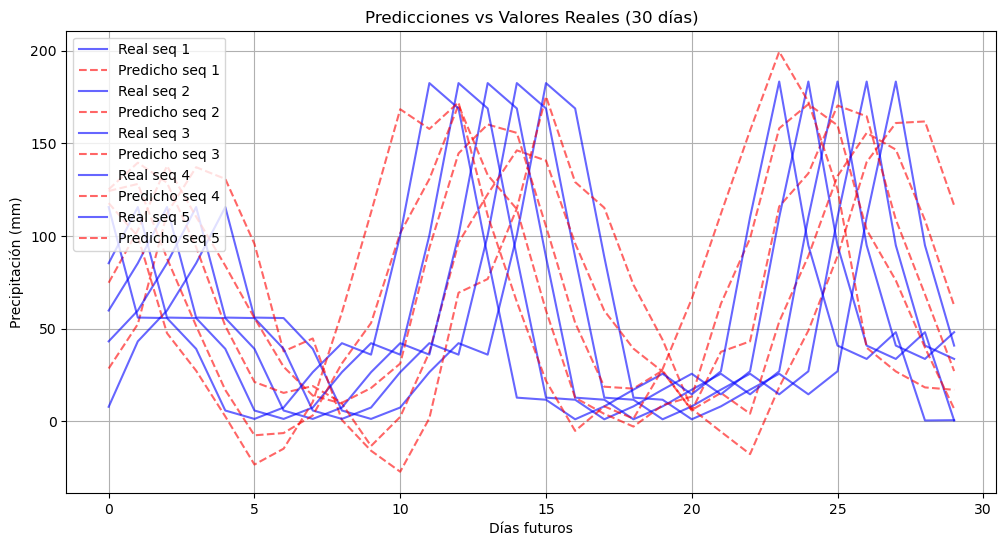

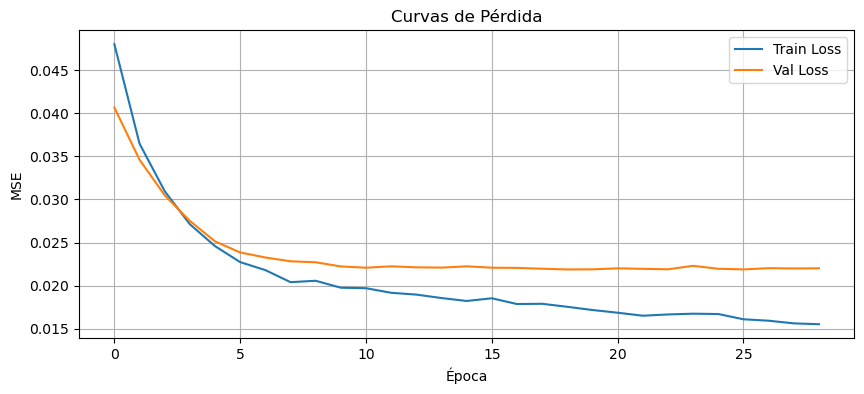

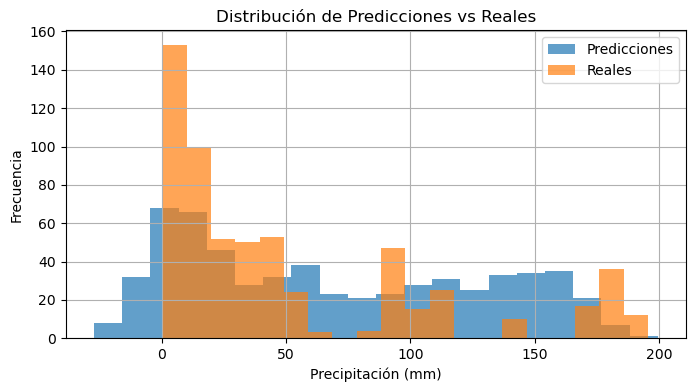

In [145]:
# === Flujo Principal ===
# Asumimos que ya tienes X_train_seq, y_train_seq, etc. del código anterior
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLPredictor(input_size=864, hidden_size=128, output_size=30, dropout=0.2).to(device)

# Entrenar
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=100, lr=0.0003, patience=10)

# Evaluar
evaluate_and_plot(model, test_loader, scaler_y, y_test, input_window=60, output_window=30)

Métricas en test:
MAE: 30.2599 mm ->cada predicción de precipitación difiere en promedio ~30 mm del valor real

MSE: 1595.6398 mm² -> algunos errores grandes están aumentando mucho el valor del MSE, por eso es más alto que el MAE

RMSE: 39.9455 mm -> significa que en general, las predicciones se desvían alrededor de ~40 mm de los valores reales, considerando que los errores grandes pesan más

Predicción de los próximos 30 días:
[ 41.39486     8.443754   10.178716   -1.0105326  24.787752   56.776814
 113.46788   138.44812   163.12717   150.58061   100.95034    80.360695
  29.164948    3.549304  -12.917561    6.918402   35.437996   45.384964
  90.19203   127.2084    132.17062   144.9396    105.5199     50.1377
  14.916122   -8.56591    -3.103429   -2.4560592   5.0489655  51.715134 ]
Porcentaje de error aproximado: 74.89%


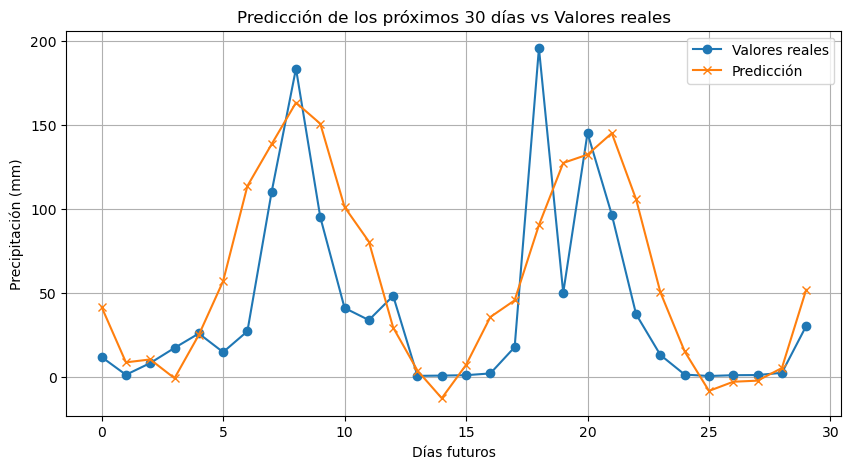

In [146]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Tomar la última secuencia del conjunto de test
last_seq = X_test_seq[-1]
last_seq_tensor = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0).to(device)

# Predicción
model.eval()
with torch.no_grad():
    pred_next_30 = model(last_seq_tensor).cpu().numpy()

# Desnormalizar
pred_next_30_inv = scaler_y.inverse_transform(pred_next_30)
print("Predicción de los próximos 30 días:")
print(pred_next_30_inv.flatten())

#  comparar con los valores reales del test (última secuencia)
actual_next_30 = y_test_seq[-1]  # ya está normalizado
actual_next_30_inv = scaler_y.inverse_transform(actual_next_30.reshape(1, -1))

# Calcular porcentaje de error (MAE relativo)
mae = mean_absolute_error(actual_next_30_inv.flatten(), pred_next_30_inv.flatten())
mean_actual = actual_next_30_inv.flatten().mean()
percent_error = (mae / mean_actual) * 100
print(f"Porcentaje de error aproximado: {percent_error:.2f}%")

# Graficar
plt.figure(figsize=(10,5))
plt.plot(range(30), actual_next_30_inv.flatten(), label='Valores reales', marker='o')
plt.plot(range(30), pred_next_30_inv.flatten(), label='Predicción', marker='x')
plt.title('Predicción de los próximos 30 días vs Valores reales')
plt.xlabel('Días futuros')
plt.ylabel('Precipitación (mm)')
plt.legend()
plt.grid(True)
plt.show()

